In [55]:
import os, sys, time
import tifffile as tif
sys.path.append("/home/emilyjanedennis/Desktop/GitHub/rat_BrainPipe")
from tools.utils.io import makedir
from tools.registration.register import change_interpolation_order, transformix_command_line_call
from tools.registration.transform_list_of_points import modify_transform_files
from scipy.ndimage.interpolation import zoom
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv

# If you need to determine the percent voxel change between two images follow these steps first. 

## If you already have a "percent.csv" file, skip to next section

In [251]:
src = "/home/emilyjanedennis/Desktop/for_registration_to_lightsheet"
affinefile = os.path.join(src, "output_dirs/Chon_to_PRA_affine/result.tif")
transformixedfile = os.path.join(src, "output_dirs/Chon_for_PRA/result.tif")
annotationsfilename = os.path.join(src,"labels/chon_label_ids.csv")
voxcsv = os.path.join(src,"Chon_to_PRA_vox.csv")
percentcsv = os.path.join(src,"Chon_to_PRA_percent.csv")
transformixed_relative_ZEROED_tiff = os.path.join(src,"Chon_to_PRA_relative_ZEROED_tiff.tif")
transformixed_relative_tiff = os.path.join(src,"Chon_to_PRA_relative_tiff.tif")

In [252]:
affine = tif.imread(affinefile)
print("read affine tiff")
transformixed = tif.imread(transformixedfile)
print("read transformixed tiff")

read affine tiff
read transformixed tiff


In [253]:
# make sure your annotations have the first column as id number, 2nd as abbreviation, or else change the input below
anns=pd.read_csv(annotationsfilename,usecols=[0,1],header=0,names=['id','abbr'])
print("read annotations")

read annotations


In [254]:
df=anns.dropna()
df

,id,abbr
0,1,VTM
1,2,S1ULp-6b
2,3,sf
3,4,IC
4,6,ic
...,...,...
4284,58500,8Cb-mo
4285,59100,9Cb-gr
4286,58900,9Cb-mo
4287,59500,10Cb-gr


In [255]:
df.insert(2,'affine_vox',0)
df.insert(3,'transformixed_vox',0)


In [ ]:
for i in df['id']:
    df.transformixed_vox[df.index[df.id==i]] = np.size(transformixed[transformixed==i])
    df.affine_vox[df.index[df.id==i]] = np.size(affine[affine==i])


<ipython-input-271-ec990ef16611>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.transformixed_vox[df.index[df.id==i]] = np.size(transformixed[transformixed==i])
<ipython-input-271-ec990ef16611>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.affine_vox[df.index[df.id==i]] = np.size(affine[affine==i])


In [ ]:
df

In [167]:
df['change'] = df['affine_vox']-df['transformixed_vox']

In [168]:
dfwithzero=df

In [182]:
df = df[df.transformixed_vox > 0]
zs = dfwithzero.id


1294

In [144]:
dfpercent = (df['change']/df['transformixed_vox'])*100
dfpercent[np.isinf(dfpercent)]=0
df['percent'] = dfpercent
dfpercent.replace(0,np.nan)

0       -4.234743
1        1.645973
2       -4.921634
3       -0.619586
4        5.729901
          ...    
2985    23.456790
2986   -10.416667
2987    19.791667
2988     8.571429
2989    -5.050505
Length: 2990, dtype: float64

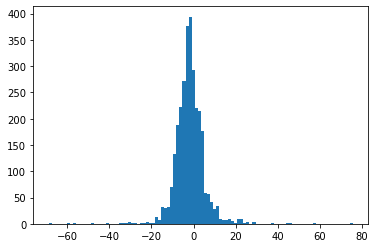

In [145]:
plt.hist(df.percent,bins=100)
plt.show()

In [146]:
mp = np.nanmedian(df.percent)
sp = np.nanstd(df.percent)

In [147]:
highmp = mp+sp
highmp

5.244225240041913

In [148]:
lowmp = mp-sp
lowmp

-8.964993574142763

In [129]:
df.to_csv(percentcsv)

In [130]:
df=pd.read_csv(percentcsv)

In [133]:
df

,Unnamed: 0,id,abbr,affine_vox,transformixed_vox,change,percent
0,0,1,VTM,21687,22646,-959,-4.234743
1,1,2,S1ULp-6b,35694,35116,578,1.645973
2,2,3,sf,16015,16844,-829,-4.921634
3,3,4,IC,17323,17431,-108,-0.619586
4,4,6,ic,294831,278853,15978,5.729901
...,...,...,...,...,...,...,...
2985,4097,6222,S1DZO-2/3,100,81,19,23.456790
2986,4098,6223,S1DZO-4,86,96,-10,-10.416667
2987,4099,6224,S1DZO-5,460,384,76,19.791667
2988,4100,6225,S1DZO-6a,76,70,6,8.571429


In [186]:
too = df.id
zeroed = dfwithzero.id

In [187]:
transformixed_relative = transformixed

In [217]:
# add list of unique values not in twoxh/twoxl but in transformixed
transformixed = tif.imread(transformixedfile)
x = np.unique(testvol)
np.size(x)

10738

In [200]:
test = np.setdiff1d(x,too)
test[1:20]

array([ 5, 13, 18, 24, 25, 29, 32, 40, 47, 49, 53, 57, 61, 69, 70, 72, 76,
       77, 80], dtype=int16)

In [77]:
for i in test:
    transformixed_relative[transformixed_relative==i]=0

In [78]:
tif.imsave(transformixed_relative_ZEROED_tiff,transformixed_relative)

In [79]:
for i in too:
    transformixed_relative[transformixed_relative==i]=df.loc[df['id']==i,'percent'].iloc[0]

In [80]:
tif.imsave(transformixed_relative_tiff,transformixed_relative)

# If you already have a percent file

In [81]:
df=pd.read_csv(percentcsv)

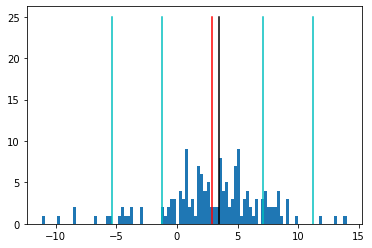

In [82]:
plt.hist(df.percent[df.affine_vox>5],bins=100)

dfmean = np.nanmean(df.percent[df.affine_vox>5])
dfmedian = np.nanmedian(df.percent[df.affine_vox>5])
dfstd = np.std(df.percent[df.affine_vox>5])
mp = dfmean + dfstd
mm = dfmean - dfstd

mp2 = dfmean + 2*dfstd
mp3 = dfmean + 3*dfstd
mm2 = dfmean - 2*dfstd
mm3 = dfmean - 3*dfstd


plt.plot([dfmean, dfmean],[0,25],'r')
plt.plot([dfmedian, dfmedian],[0,25],'k')
plt.plot([mp,mp],[0,25],'c')
plt.plot([mm,mm],[0,25],'c')
plt.plot([mp2,mp2],[0,25],'c')
plt.plot([mm2,mm2],[0,25],'c')
plt.show()

In [83]:
# want to make summary -- ideally show a ranked 3, 2, 1std>mean 
# in diff colors, and then the 
# values either written or in bar form on the right

df

,Unnamed: 0,id,abbr,affine_vox,transformixed_vox,change,percent
0,1,2,AIP,389370,370564,18806,5.074967
1,2,3,AIV,283199,281826,1373,0.487180
2,3,4,APir,258438,246453,11985,4.862996
3,4,5,Au1,634157,589051,45106,7.657401
4,5,6,AuD,310826,290206,20620,7.105298
...,...,...,...,...,...,...,...
149,150,132,FimbriaL,630631,658444,-27813,-4.224049
150,151,134,CorpColloL,988558,1045616,-57058,-5.456879
151,152,136,AmygL,1047422,990460,56962,5.751065
152,153,138,PreopAreaL,426088,422010,4078,0.966328


In [84]:
df2p = df[df.percent>mp2]
df2p = df2p.sort_values('percent',ascending=False)
df2m = df[df.percent < mm2]
df2m = df2m.sort_values('percent',ascending=False)

In [85]:
df2m

,Unnamed: 0,id,abbr,affine_vox,transformixed_vox,change,percent
150,151,134,CorpColloL,988558,1045616,-57058,-5.456879
69,70,133,CorpCollo,1057553,1122489,-64936,-5.785001
146,147,126,HippFormL,2226512,2387175,-160663,-6.730256
77,78,149,Ventricles,52591,57498,-4907,-8.534210
65,66,125,HippForm,2269373,2482259,-212886,-8.576301
139,140,112,HindbrL,4298318,4762565,-464247,-9.747835
58,59,111,Hindbr,4091615,4604107,-512492,-11.131192


In [86]:
df2p

,Unnamed: 0,id,abbr,affine_vox,transformixed_vox,change,percent
118,119,87,S1ULpL,563086,493930,69156,14.001174
110,111,79,S1BFL,926206,818878,107328,13.106714
29,30,31,S1BF,897201,802626,94575,11.783197


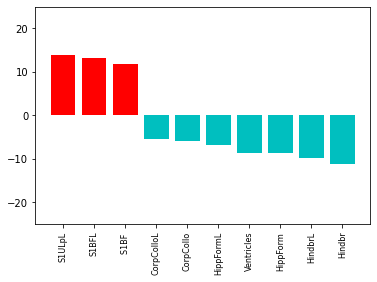

In [87]:
plt.bar(df2p.abbr,df2p.percent,color='r')
plt.bar(df2m.abbr,df2m.percent,color='c')
plt.xticks(rotation=90,fontsize=8)
plt.ylim([-25,25])
plt.show()

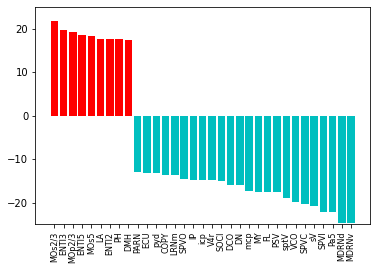

In [54]:
plt.bar(df2p.abbr,df2p.percent,color='r')
plt.bar(df2m.abbr,df2m.percent,color='c')
plt.xticks(rotation=90,fontsize=8)
plt.ylim([-25,25])
plt.show()